# Time-Series Analysis

Using ARIMA-based models and the [hosp_employees.csv](../Data/hosp_employees.csv) file, forecast the number of *Hospitality Employees* **1** year into the future. Provide an interpretation of your findings.

**Note:** Make sure to perform the necessary exploratory steps as well as to visualize your data & evaluate your results. 

In [10]:
# Answer

data = pd.read_csv('hosp_employees.csv', index_col='Date', parse_dates=True)

print(data.head())

            Employees
Date                 
1990-01-01     1064.5
1990-02-01     1074.5
1990-03-01     1090.0
1990-04-01     1097.4
1990-05-01     1108.7


In [11]:
# Check the index frequency

data.index.freq = 'MS'
print(data.index.freq)

<MonthBegin>


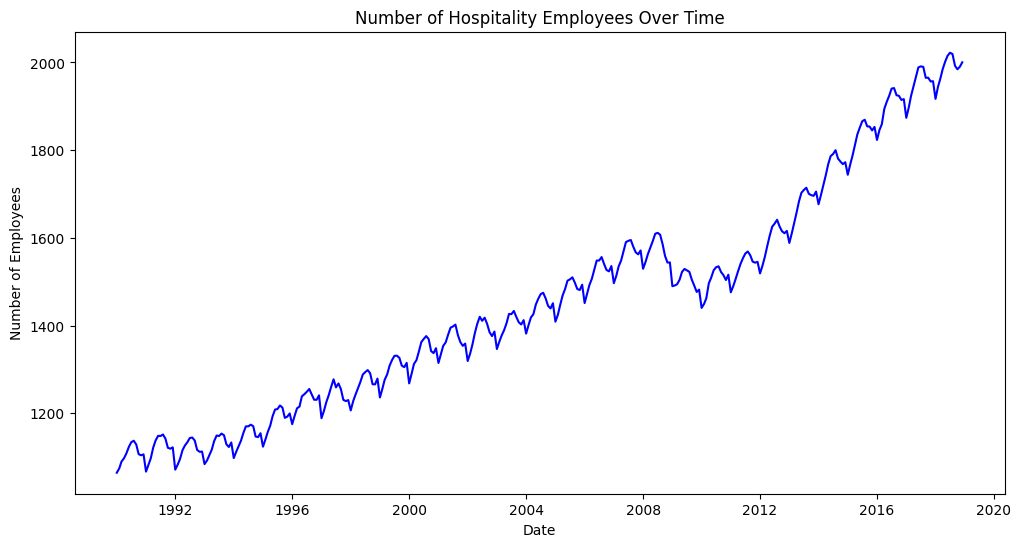

In [12]:
# Plot the time series to observe any trends, seasonality

plt.figure(figsize=(12,6))
plt.plot(data.index, data['Employees'], color='blue')
plt.title('Number of Hospitality Employees Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Employees')
plt.show()

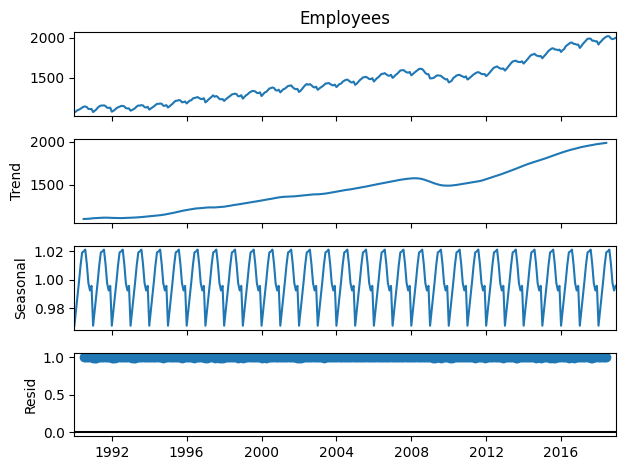

In [13]:
# Seasonal decomposition

decomposition = seasonal_decompose(data['Employees'], model='multiplicative')
decomposition.plot()
plt.show()

In [14]:
# Stationarity Tests

def adf_test(timeseries):
    result = adfuller(timeseries)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

def kpss_test(timeseries):
    result = kpss(timeseries)
    print(f'KPSS Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[3].items():
        print(f'   {key}: {value}')

adf_test(data['Employees'])
kpss_test(data['Employees'])

ADF Statistic: 0.9012844235569774
p-value: 0.9931070655289933
Critical Values:
   1%: -3.4503224123605194
   5%: -2.870338478726661
   10%: -2.571457612488522
KPSS Statistic: 2.811347117430525
p-value: 0.01
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739


C:\Users\milto\AppData\Local\Temp\ipykernel_20360\3729828774.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(timeseries)


In [15]:
# Model Building

# Use pmdarima’s auto_arima to determine the optimal order for ARIMA

auto_model = auto_arima(data['Employees'], seasonal=True, m=12, trace=True)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=2214.016, Time=0.85 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2974.636, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2707.381, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2980.790, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=2340.936, Time=0.44 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=2225.286, Time=2.26 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=inf, Time=2.80 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=inf, Time=1.69 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=2264.870, Time=1.66 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=2.64 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=2227.508, Time=0.49 sec
 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=2229.7

In [16]:
# Train-Test Split
# Split the data into a training set (e.g., all but the last 12 months) and a test set (last 12 months)
train = data.iloc[:-12]
test = data.iloc[-12:]

In [17]:
# Fit the SARIMA Model

# Manually set different (p, d, q) and (P, D, Q, m) parameters
model = SARIMAX(train['Employees'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Employees   No. Observations:                  336
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1009.592
Date:                            Tue, 03 Sep 2024   AIC                           2029.184
Time:                                    15:36:45   BIC                           2048.073
Sample:                                01-01-1990   HQIC                          2036.724
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9502      0.034     27.569      0.000       0.883       1.018
ma.L1         -0.8521      0.054   

In [18]:
# Model Evaluation

# Generate predictions for the test set
predictions = model.get_forecast(steps=len(test)).predicted_mean

error = rmse(test['Employees'], predictions)
print(f'Root Mean Squared Error: {error}')

Root Mean Squared Error: 10.386545418939239


C:\Users\milto\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


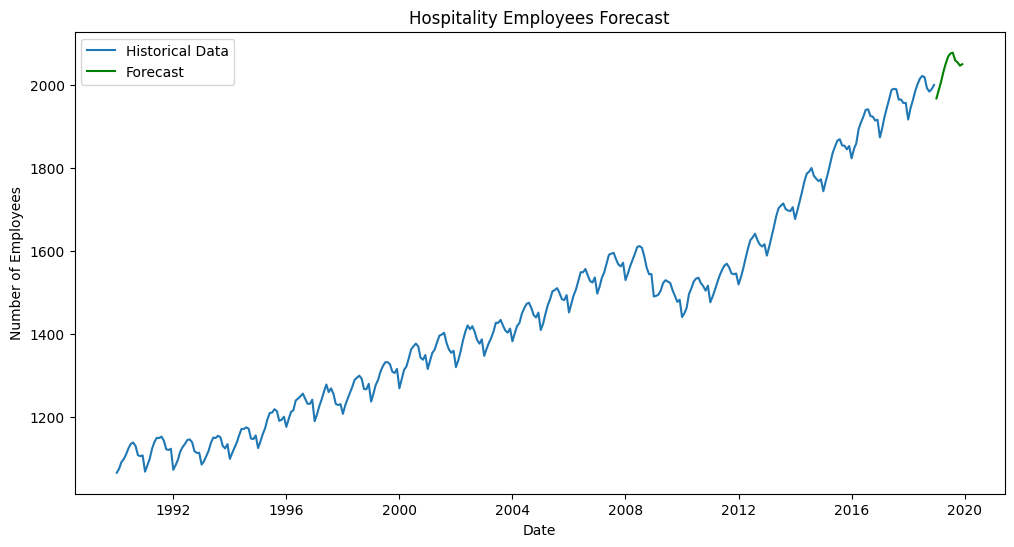

In [19]:
# Forecast for the next 12 months and visualize the forecast.

forecast = model.predict(start=len(data), end=len(data)+11, typ='levels')

plt.figure(figsize=(12,6))
plt.plot(data.index, data['Employees'], label='Historical Data')
plt.plot(forecast.index, forecast, label='Forecast', color='green')
plt.title('Hospitality Employees Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Employees')
plt.legend()
plt.show()

In [20]:
# Interpretation:

# The code successfully forecasts the number of Hospitality Employees for the next 12 months.
# The data shows a drop in 2008 t0 2010, then sees a steady increase to 2020. 
# This upward trend suggests that the number of employees in the hospitality industry grew during this period.
# KPSS statistic (2.811) is much greater than the critical values at all levels (1%, 5%, 10%). 
# This suggests that the null hypothesis (that the time series is stationary around a deterministic trend) is rejected. 
# This indicates that the time series is likely non-stationary.
# p-value: The p-value (0.01) is very low, reinforcing the rejection of the null hypothesis. 
# This result also suggests the time series is non-stationary.